# Ocean Colour time series analysis
### - Use case title: *Assess potential decrease in marine fish stock due to oceanic desertification*
### - User question: *Does the consistency of chlorophyll-a and remote sensing reflectance get affected by the succession of satellite sensors over time?*

## Take-home messages
The ESA CCI Ocean Colour dataset version 6.0:  
* provides a time consistent record of remote sensing reflectance at 443 and 560 nm, and derived chlorophyll-a concentrations, although data prior to March 2002 should be carefully evaluated.  
* would overestimate chlorophyll-a concentrations before March 2002, especially in more productive oceanic regions.  
* indicates decreasing chlorophyll-a trends at both global and regional scales.

## Introduction
The Ocean Colour dataset version 6.0, as released by the Climate Change Initiative (CCI) of the European Space Agency (ESA), includes the Essential Climate Variables (ECVs), mass concentration of chlorophyll-a and remote sensing reflectance (Rrs) for six wavelengths: 412, 443, 490, 510, 560, 665 nm. The dataset starts in October 1997 and is acquiring data at the time of writing.  
Chlorophyll-a, the most prevalent photosynthetic pigment found in phytoplankton, is typically used as proxy for algal biomass and fisheries production (Behrenfeld and Falkowski, 1997; Friedland et al., 2012). Chlorophyll-a concentration is derived through specific algorithms (Brewin et al., 2015; Jackson et al., 2017; Sathyendranath et al., 2019; Jackson et al., 2022) by using remote sensing reflectance (Rrs), which is the quantity measured directly by Ocean Colour satellite sensors.  
The ESA CCI Ocean Colour dataset version 6.0 combines daily measurements, with a spatial resolution of 4km x 4km at the Equator, from cloud- and ice-free areas carried out by six satellite sensors (Jackson et al., 2022): SeaWiFS, MERIS, MODIS-Aqua, VIIRS, OLCI-3A and OLCI-3B. No sensor was operational over the whole temporal coverage of the datasets and only OLCI-3A and OLCI-3B are still acquiring.  
Here, the goal is to assess if the consistency of Ocean Colour timeseries is affected by the transition of different satellite sensors over time.
## Materials and Methods
The analysis performed in this notebook focuses on the time series of chlorophyll-a concentration and Rrs at 443 and 560 nm, the most commonly used bands to derive chlorophyll-a data, over a 25-year period (January 1998 - December 2022).  
The analysis includes calculation of spatial-weighted and annual means, 48-month rolling means and linear trends in three selected regions: the global ocean, the oceanic region between latitudes 50°S and 50°N and the North Atlantic SubTropical Gyre (NASTG).  
The analysis excludes chlorophyll-a concentrations outside the range 0.01-100 mg m<sup>-3</sup> (Sathyendranath et al., 2019).  
Means are computed using log-transformed daily data, and then unlogged (Campbell, 1995).

## Results and Discussion
Time series of chlorophyll-a concentrations and Rrs at 443 and 560 nm are displayed below for each region analysed, together with the duration of every satellite mission used to retrieve data.  A zoomed-in scale is used to focus on long-term chlorophyll-a and Rrs trends in the three regions analysed and allow their comparison.  Linear trend equations and their statistically significance (p) are specified in the legend of each figure.  

Results show that the ESA CCI dataset version 6.0 captures both the seasonal and interannual variability of the ECVs analysed in the three selected regions.  
The largest seasonal variability is found in the ultra-oligotrophic NASTG, due to the strong seasonal expansion/contraction cycle of the gyre (Leonelli et al., 2022).  
Chlorophyll-a trend obtained through a 48-month rolling mean shows a maxima around 2002 in both the global ocean and the oceanic region between latitudes 50°S and 50°N, followed by a sharp decrease until 2004. Afterwards, a progressive decrease until around 2015 and a slight increase until 2022 are observed. Average Rrs at 443 nm in the same areas shows a reverse pattern.  
Chlorophyll-a and Rrs at 443 nm average trends display a more constant pattern in the NASTG, while Rrs at 560 nm trends are rather linear except in the NASTG, where a progressive increase between 1998 and 2017 is followed by a rapid decrease until 2022.  
Relatively high chlorophyll-a concentrations and low Rrs at 443 nm are observed when SeaWiFS was the only active satellite (i.e., from January 1998 to March 2002) in all regions except the NASTG.  

Overall, these results suggest that, prior to March 2002, Rrs at 443 would be underestimated, especially in more productive oceanic zones, and trigger chlorophyll-a overestimates.    
An additional analysis, performed using the same notebook, but excluding SeaWiFS data prior to March 2002, indicates that they do not significantly modify the long-term trends computed for the ECVs analysed here nor their statistics in all selected regions.  


variable='chlor_a' region='Global Ocean'


100%|██████████| 300/300 [00:19<00:00, 15.08it/s]


variable='chlor_a' region='Latitudes 50$^o$S-50$^o$N'


100%|██████████| 300/300 [00:17<00:00, 17.58it/s]


variable='chlor_a' region='NASTG'


100%|██████████| 300/300 [00:15<00:00, 19.15it/s]


variable='Rrs_443' region='Global Ocean'


100%|██████████| 300/300 [00:17<00:00, 17.43it/s]


variable='Rrs_443' region='Latitudes 50$^o$S-50$^o$N'


100%|██████████| 300/300 [00:19<00:00, 15.64it/s]


variable='Rrs_443' region='NASTG'


100%|██████████| 300/300 [00:17<00:00, 16.79it/s]


variable='Rrs_560' region='Global Ocean'


100%|██████████| 300/300 [00:15<00:00, 19.12it/s]


variable='Rrs_560' region='Latitudes 50$^o$S-50$^o$N'


100%|██████████| 300/300 [00:16<00:00, 17.67it/s]


variable='Rrs_560' region='NASTG'


100%|██████████| 300/300 [00:14<00:00, 20.22it/s]


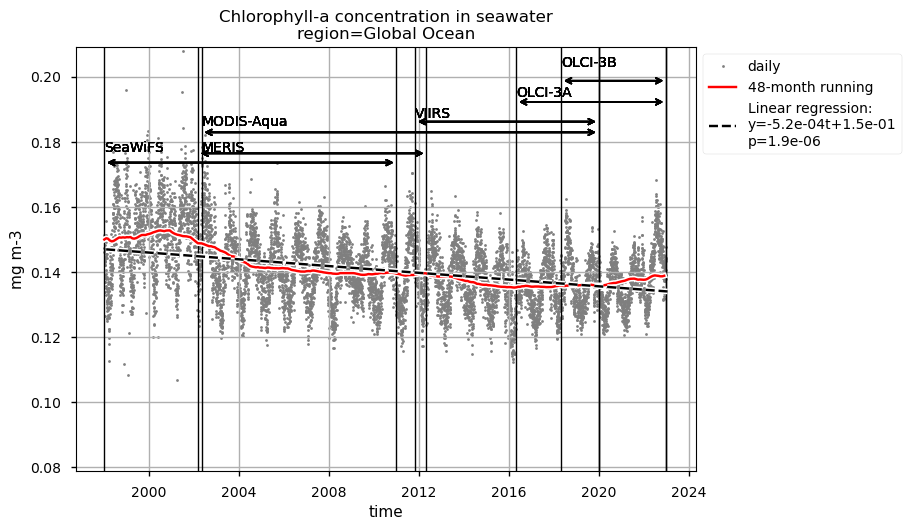

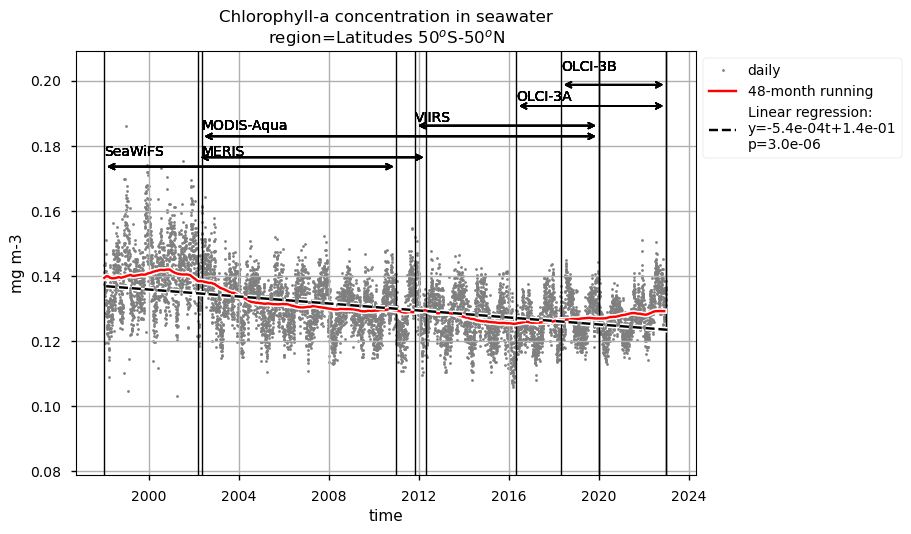

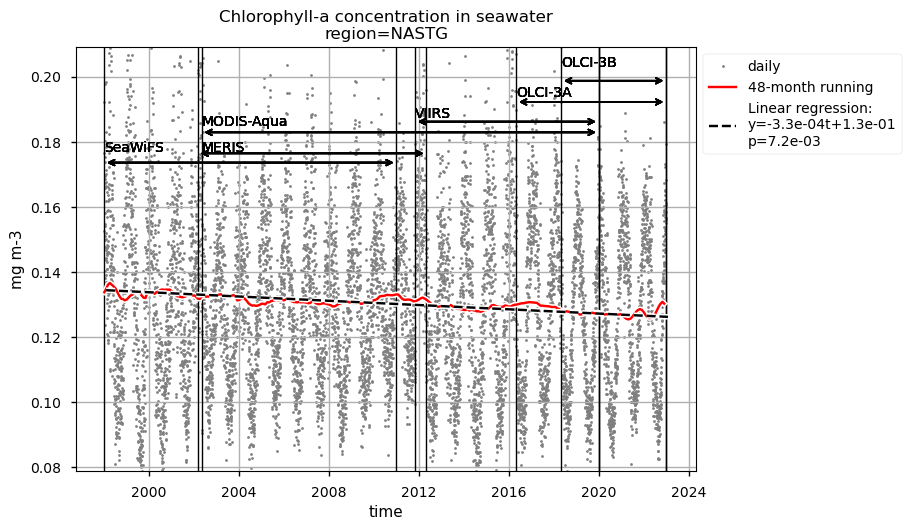

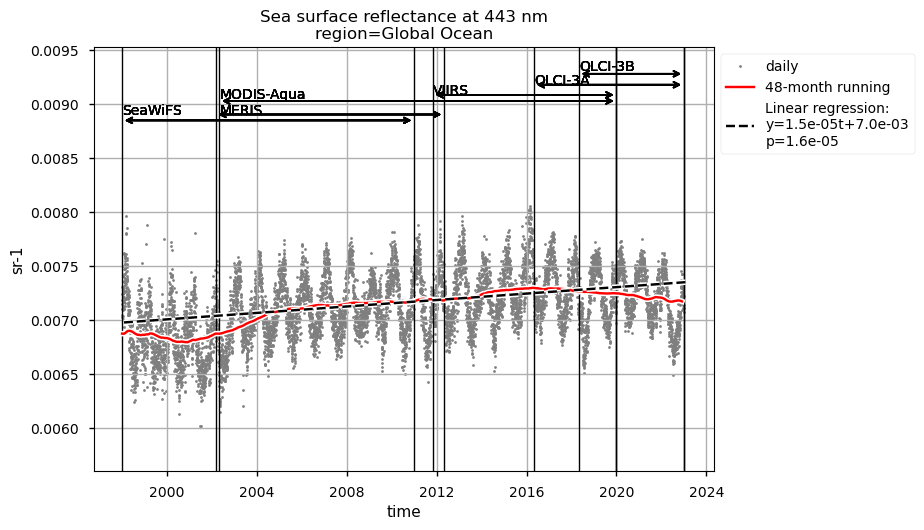

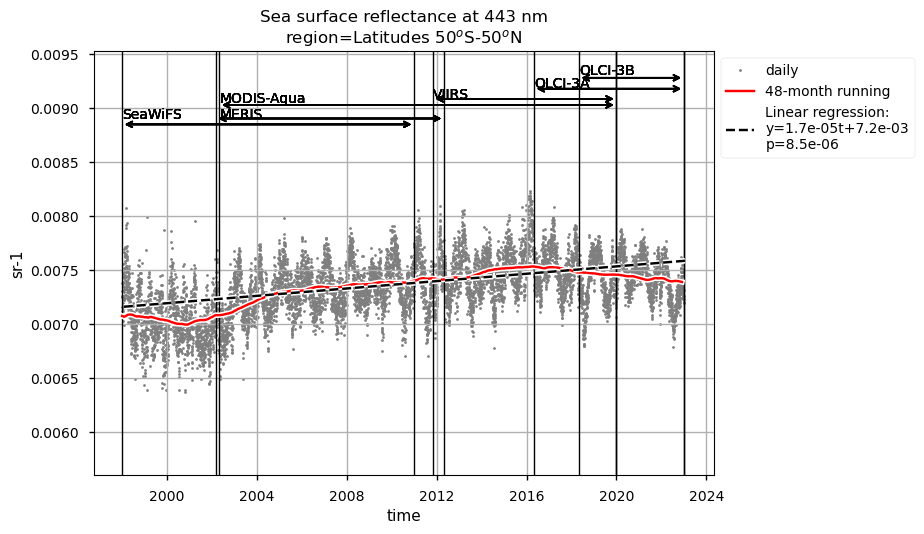

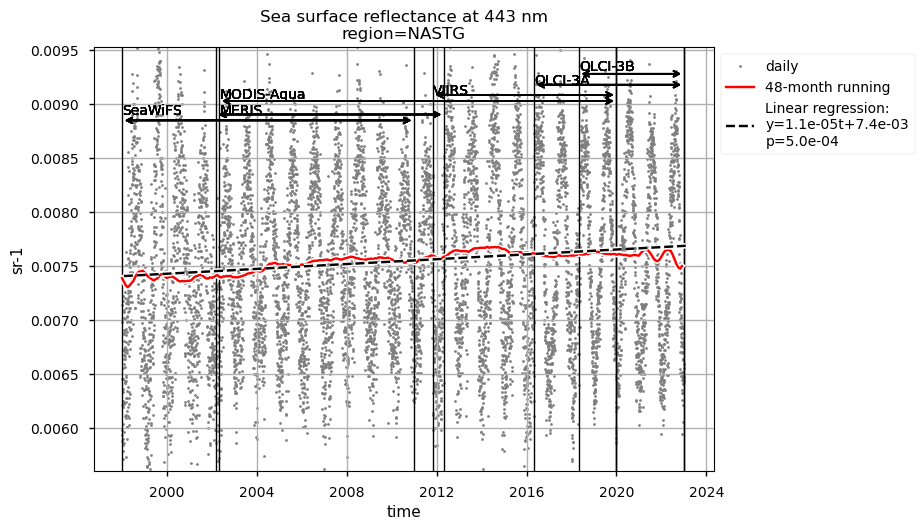

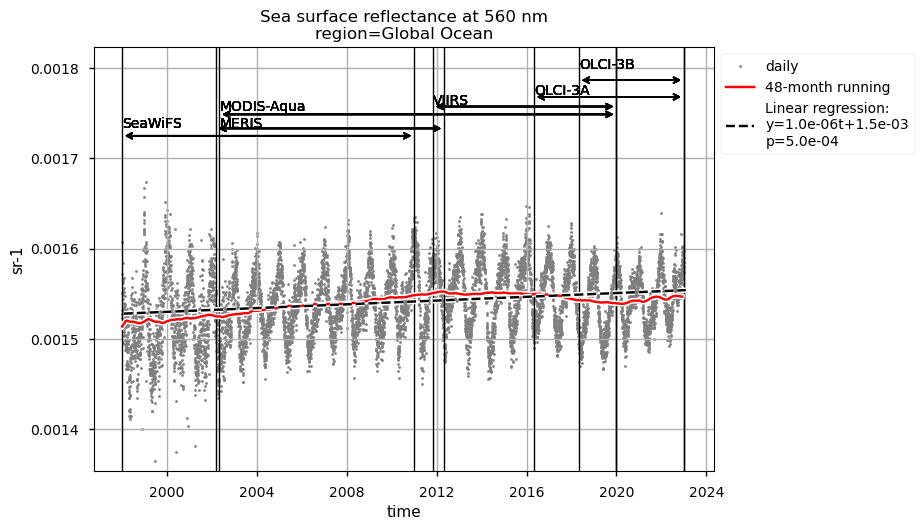

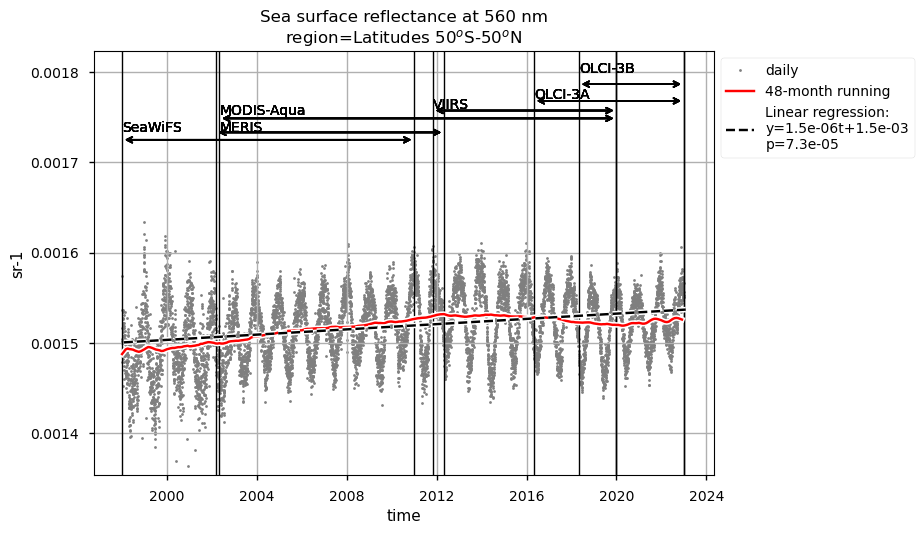

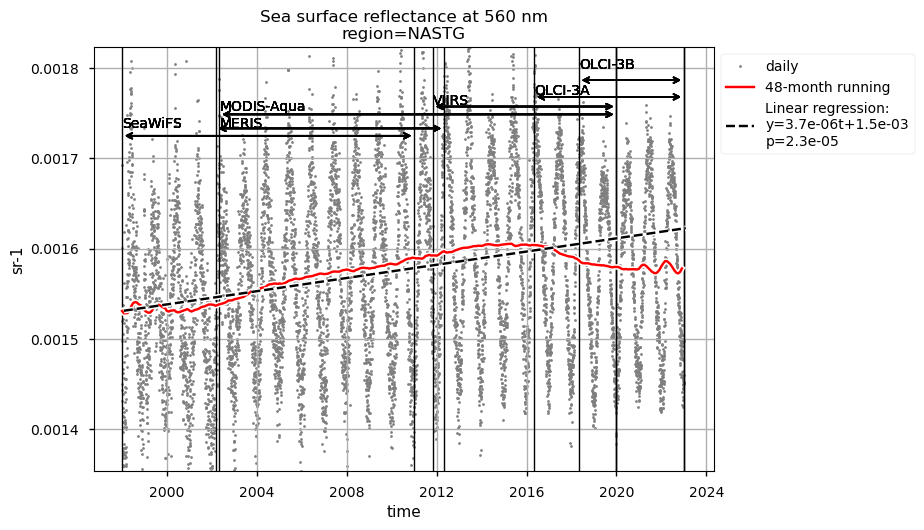

In [2]:
#________________
# Import packages
#________________

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, utils
plt.style.use("seaborn-v0_8-notebook")

#__________________
# Define parameters
#__________________

# Time period
start = "1998-01"
stop = "2022-12"

# Variables to analyse
variables = [
    "chlor_a",
    "Rrs_443",
    "Rrs_560",
]
assert set(variables) <= {"chlor_a"} | {
    f"Rrs_{wl}" for wl in (443, 560)
}

# Regions to analyse
regions = {
    "Global Ocean": {"lon_slice": slice(-180, 180), "lat_slice": slice(90, -90)},
    "Latitudes 50$^o$S-50$^o$N": {"lon_slice": slice(-180, 180), "lat_slice": slice(50, -50)},
    "NASTG": {"lon_slice": slice(-80, 0), "lat_slice": slice(50, 0)},
}
for region, slices in regions.items():
    # Enforce sorting as original data
    for k, v in slices.items():
        assert v.start >= v.stop if k == "lat_slice" else v.start <= v.stop, (region, k)

#____________________
# Define data request
#____________________

collection_id = "satellite-ocean-colour"

request = {
    "projection": "regular_latitude_longitude_grid",
    "version": "6_0",
    "format": "zip",
}

#___________________
# Functions to cache
#___________________

def regionalised_spatial_weighted_mean(ds, variable, lon_slice, lat_slice):
    da = ds[variable]
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)
    if variable == "chlor_a":
        da = da.where((da > 0.01) & (da < 1.0e2))
    with xr.set_options(keep_attrs=True):
        da = 10 ** diagnostics.spatial_weighted_mean(np.log10(da))
    da.attrs["long_name"] = da.attrs["long_name"].replace(" (not log-transformed)", "")
    return da.to_dataset(name=variable)

#____________________________
# Download and transform data
#____________________________

datasets = []
for variable in variables:
    for region, slices in regions.items():
        print(f"{variable=} {region=}")
        requests = download.update_request_date(
            request
            | {
                "variable": "remote_sensing_reflectance"
                if variable.startswith("Rrs")
                else "mass_concentration_of_chlorophyll_a"
            },
            start=start,
            stop=stop,
            stringify_dates=True,
        )
        ds = download.download_and_transform(
            collection_id,
            requests,
            transform_func=regionalised_spatial_weighted_mean,
            transform_func_kwargs={"variable": variable} | slices,
            chunks={"year": 1, "month": 1, "variable": 1},
        )
        datasets.append(ds.expand_dims(region=[region]))
ds = xr.merge(datasets).compute()

#__________________________
# Define plotting functions
#__________________________

def plot_timeseries(da):
    fig, ax = plt.subplots(1, 1)

    # Compute variables
    da_daily = da.resample(time="D").mean()
    da_yearly = da.resample(time="12ME").mean()
    da_running = (
        da.resample(time="MS")
        .mean()
        .rolling(time=48, center=True, min_periods=1)
        .mean()
    )
    trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(
        da_yearly.squeeze()
    )

    # Plots lines
    da_daily.plot(
        label="daily", ms=4, color="tab:grey", ls=" ", marker=".", ax=ax, zorder=1
    )
    da_running.plot(
        add_legend=False,
        label="48-month running",
        color="r",
        ls="-",
        marker=" ",
        ax=ax,
        path_effects=[pe.Stroke(linewidth=4, foreground="w"), pe.Normal()],
        zorder=3,
    )
    ax.plot(
        da_yearly["time"],
        np.arange(da_yearly.sizes["time"]) * slope + intercept,
        label=f'Linear regression:\ny={slope:.1e}t+{intercept:.1e}\n{p=:.1e}',
        color="k",
        ls="--",
        marker=" ",
        path_effects=[pe.Stroke(linewidth=4, foreground="w"), pe.Normal()],
        zorder=3,
    )
    # Final settings
    ax.set_ylim(da.quantile([0.001, 0.999]).values.tolist())
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid()
    return fig, ax
    
missions = {
    'mission1': {
        'mission': 'SeaWiFS',
        'start': np.datetime64('1998-01-01'),
        'stop': np.datetime64('2010-12-31'),
        'linestyle': '-',
    },
    'mission2': {
        'mission': 'MERIS',
        'start': np.datetime64('2002-03-01'),
        'stop': np.datetime64('2012-04-30'),
        'linestyle': '-' ,
    },
    'mission3': {
        'mission': 'MODIS-Aqua',
        'start': np.datetime64('2002-05-01'),
        'stop': np.datetime64('2019-12-31'),
        'linestyle': '-' ,
    },
    'mission4': {
        'mission': 'VIIRS',
        'start': np.datetime64('2011-11-01'),
        'stop': np.datetime64('2019-12-31'),
        'linestyle': '-' ,
    },
    'mission5': {
        'mission': 'OLCI-3A',
        'start': np.datetime64('2016-05-01'),
        'stop': np.datetime64('2022-12-31'),
        'linestyle': '-' ,
    },
    'mission6': {
        'mission': 'OLCI-3B',
        'start': np.datetime64('2018-05-01'),
        'stop': np.datetime64('2022-12-31'),
        'linestyle': '-' ,
    },
}

#___________________
# Displaying figures
#___________________

for variable in variables:
    for region in regions:
        fig, ax = plot_timeseries(ds[variable].sel(region=[region]))
        if variable == "chlor_a": 
            ax.set_title(f"Chlorophyll-a concentration in seawater\n{region=:s}")
            ax.set_ylabel("mg m-3")
        if variable == "Rrs_443": 
            ax.set_title(f"Sea surface reflectance at 443 nm\n{region=:s}")
            ax.set_ylabel(f"{ds[variable].attrs['units']}")
        if variable == "Rrs_560": 
            ax.set_title(f"Sea surface reflectance at 560 nm\n{region=:s}")
            ax.set_ylabel(f"{ds[variable].attrs['units']}")
        ax.set_ylim(ds[variable].quantile([0.001, 0.999]).values.tolist())
        for mission_name, mission in missions.items():   
            mission_start = mission['start']
            mission_stop = mission['stop']
            linestyle = mission['linestyle']
            plt.axvline(mission_start, color='black', linestyle=linestyle, lw=1.0)
            plt.axvline(mission_stop, color='black', linestyle=linestyle, lw=1.0)
            plt.annotate('', xy=(np.datetime64('1998-01-01'), ds[variable].quantile(0.981).values), xytext=(np.datetime64('2010-12-31'), ds[variable].quantile(0.981).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2002-03-01'), ds[variable].quantile(0.985).values), xytext=(np.datetime64('2012-04-30'), ds[variable].quantile(0.985).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2002-05-01'), ds[variable].quantile(0.991).values), xytext=(np.datetime64('2019-12-31'), ds[variable].quantile(0.991).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2011-11-01'), ds[variable].quantile(0.993).values), xytext=(np.datetime64('2019-12-31'), ds[variable].quantile(0.993).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2016-05-01'), ds[variable].quantile(0.995).values), xytext=(np.datetime64('2022-12-31'), ds[variable].quantile(0.995).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2018-05-01'), ds[variable].quantile(0.997).values), xytext=(np.datetime64('2022-12-31'), ds[variable].quantile(0.997).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.text(np.datetime64('1998-01-01'), ds[variable].quantile(0.987).values.tolist(), 'SeaWiFS', ha='left', va='center')
            plt.text(np.datetime64('2002-05-01'), ds[variable].quantile(0.987).values.tolist(), 'MERIS', ha='left', va='center')
            plt.text(np.datetime64('2002-05-01'), ds[variable].quantile(0.993).values.tolist(), 'MODIS-Aqua', ha='left', va='center')
            plt.text(np.datetime64('2011-11-01'), ds[variable].quantile(0.994).values.tolist(), 'VIIRS', ha='left', va='center')
            plt.text(np.datetime64('2016-05-01'), ds[variable].quantile(0.996).values.tolist(), 'OLCI-3A', ha='left', va='center')
            plt.text(np.datetime64('2018-05-01'), ds[variable].quantile(0.998).values.tolist(), 'OLCI-3B', ha='left', va='center')
plt.show()

#### REFERENCES
Behrenfeld, M.J., & Falkowski, P.G. (1997). A consumer's guide to phytoplankton primary productivity models. Limnology and Oceanography, 42, 1479-1491. https://doi.org/10.4319/lo.1997.42.7.1479.

Brewin, R.J., et al. (2015). The Ocean Colour Climate Change Initiative: III. A round-robin comparison on in-water bio-optical algorithms. Remote Sensing of Environment, 162, 271-294.

Campbell, J.W. (1995). The lognormal distribution as a model for bio-optical variability in the sea. Journal of Geophysical Research, 100, 13237-13254. https://doi.org/10.1029/95JC00458.

Friedland, K.D., et al. (2012). Pathways between Primary Production and Fisheries Yields of Large Marine Ecosystems. PLoS ONE, 7(1), e28945. https://doi.org/10.1371/journal.pone.0028945.

Jackson, T., et al. (2017). An improved optical classification scheme for the Ocean Colour Essential Climate Variable and its application. Remote Sensing of Environment, 203, 152-161. https://doi.org/10.1016/j.rse.2017.03.036.

Jackson, T., et al. (2022). Ocean colour daily data from 1997 to present derived from satellite observations, Version 6.0. Copernicus Climate Change Service (C3S) Data Store (CDS), accessed 13 September 2023, https://doi.org/10.24381/cds.f85b319d.

Leonelli, F.E., et al. (2022). Ultra-oligotrophic waters expansion in the North Atlantic Subtropical Gyre revealed by 21 years of satellite observations. Geophysical Research Letters, 49, e2021GL096965. https://doi.org/10.1029/2021GL096965.

Sathyendranath, S., et al. (2019). An Ocean-Colour time series for use in climate studies: the experience of the Ocean-Colour Climate Change Initiative (OC-CCI). Sensors, 19, 4285. https://doi.org/10.3390/s19194285.